<a href="https://colab.research.google.com/github/Dyakonov/ml_hacks/blob/master/dj_XOR_20230215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пример решения задачи XOR

* Для занятий по курсу Дьяконова Александра

* сделано по https://uvadlc-notebooks.readthedocs.io

### подгружаем библиотеки

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.colors import to_rgba

### создаём модель

In [81]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # тут просто прописаны слои
        self.linear1 = nn.Linear(num_inputs, num_hidden) # линейный модуль
        self.act_fn = nn.Tanh() # активация Tanh
        self.linear2 = nn.Linear(num_hidden, num_outputs) # линейный модуль

    def forward(self, x):
        # тут самое главное: вход -> выход
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

model = SimpleClassifier(num_inputs=2, # число входов
                         num_hidden=4, # число скрытых слоёв
                         num_outputs=1) # число выходов

print(model) # выводим модель

# смотрим на параметры
for name, param in model.named_parameters():
    print(f"Parameter={name}, shape={param.shape}")

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)
Parameter=linear1.weight, shape=torch.Size([4, 2])
Parameter=linear1.bias, shape=torch.Size([4])
Parameter=linear2.weight, shape=torch.Size([1, 4])
Parameter=linear2.bias, shape=torch.Size([1])


### как работает модель

In [82]:
x = torch.randn((5, 2)) # случайный тензор размера 5x2
print ('вход', x)
y = model(x)
print ('выход', y)

вход tensor([[ 1.6725, -1.6343],
        [ 1.5904,  0.2796],
        [-0.4819, -0.9475],
        [-1.6951, -0.3777],
        [-1.2407, -1.0107]])
выход tensor([[-0.7816],
        [-0.0199],
        [-0.8685],
        [-0.8211],
        [-0.9208]], grad_fn=<AddmmBackward0>)


In [83]:
model.linear1(x) # что будет после первого линейного модуля

tensor([[-0.7484,  0.5951,  0.8472, -0.7925],
        [-0.2005, -0.4659, -0.4375, -0.5801],
        [ 0.5986,  1.2065, -0.1354,  0.4749],
        [ 1.4052,  1.4457, -0.8097,  1.2046],
        [ 0.9927,  1.5971, -0.2799,  0.8948]], grad_fn=<AddmmBackward0>)

### где будем вычислять

In [85]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


## данные

In [86]:
import torch.utils.data as data

class XORDataset(data.Dataset):

    def __init__(self, size, std=0.3): # !!! 0.1 -> 0.3
        """
        Inputs:
            size - число точек
            std - уровень шума
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Обычная задача XOR 1 - (0, 1), (1, 0); 0 - (0, 0), (1, 1)
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # добавляем шум
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # размер датасета  ~ self.data.shape[0] | self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # idx-й элемент датасета
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [87]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([ 0.1126, -0.1501]), tensor(0))


In [88]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

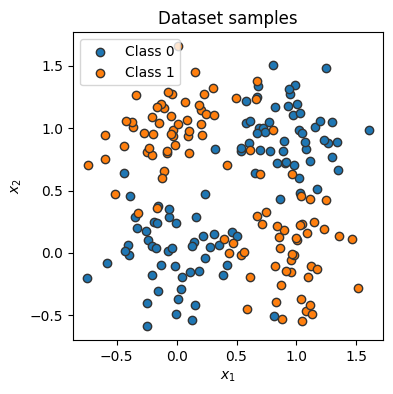

In [89]:
visualize_samples(dataset.data, dataset.label)
plt.show()

# Загрузчик данных - DataLoader

In [90]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

# next(iter(...)) - первый батч
data_inputs, data_labels = next(iter(data_loader))

# размеры
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[-0.0435,  0.9526],
        [-0.3502,  0.2896],
        [ 0.8946,  0.1866],
        [ 0.5343,  0.8192],
        [ 0.6824,  1.3359],
        [ 0.6504,  0.6376],
        [-0.2288,  0.8416],
        [ 1.1486,  0.2511]])
Data labels torch.Size([8]) 
 tensor([1, 0, 1, 0, 0, 0, 1, 1])


# готовимся к обучению

In [91]:
# функция ошибки
loss_module = nn.BCEWithLogitsLoss()

In [92]:
# оптимизатор <- model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [93]:
# датасет (делаем большой) и загрузчик
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [94]:
# модель -> вычислитель
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [95]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # режим обучения
    model.train()

    # цикл по эпохам
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## 1 - данные на GPU (если надо)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## 2 данные в модель (прямой проход)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # [Batch size, 1] -> [Batch size]

            ## 3 - ошибка
            loss = loss_module(preds, data_labels.float())

            ## 4 - обнулить градиенты
            optimizer.zero_grad(set_to_none=True)
            # 5 - обратный проход
            loss.backward()

            ## 6 - меняем параметры
            optimizer.step()

In [96]:
train_model(model, optimizer, train_data_loader, loss_module, num_epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [97]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-1.8794, -0.5766],
        [-1.0880, -2.1768],
        [ 1.3035, -1.5430],
        [-2.5181,  2.9322]])), ('linear1.bias', tensor([ 2.0571,  0.4943, -1.9381,  1.5468])), ('linear2.weight', tensor([[ 5.7689, -5.7163,  1.7715, -4.6243]])), ('linear2.bias', tensor([-1.5068]))])


In [98]:
# сохранить модель
torch.save(state_dict, "our_model.tar")

In [99]:
# загрузить состояние сети
state_dict = torch.load("our_model.tar")

# создать модель и загрузить состояние
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# проверим, совпадают ли параметры
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-1.8794, -0.5766],
        [-1.0880, -2.1768],
        [ 1.3035, -1.5430],
        [-2.5181,  2.9322]])), ('linear1.bias', tensor([ 2.0571,  0.4943, -1.9381,  1.5468])), ('linear2.weight', tensor([[ 5.7689, -5.7163,  1.7715, -4.6243]])), ('linear2.bias', tensor([-1.5068]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-1.8794, -0.5766],
        [-1.0880, -2.1768],
        [ 1.3035, -1.5430],
        [-2.5181,  2.9322]])), ('linear1.bias', tensor([ 2.0571,  0.4943, -1.9381,  1.5468])), ('linear2.weight', tensor([[ 5.7689, -5.7163,  1.7715, -4.6243]])), ('linear2.bias', tensor([-1.5068]))])


In [100]:
test_dataset = XORDataset(size=500)
# drop_last не удалять последний батч, даже если он меньше 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [101]:
def eval_model(model, data_loader):
    model.eval() # тест
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # не вычислять градиенты
        for data_inputs, data_labels in data_loader:

            # определить прогнозы
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid
            pred_labels = (preds >= 0.5).long() # округление

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [102]:
eval_model(model, test_data_loader)

Accuracy of the model: 86.40%


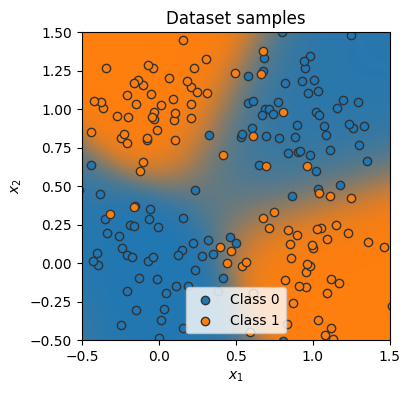

In [108]:
@torch.no_grad() # декоратор - такой же эффект как "with torch.no_grad(): ..."
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2) # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    model_inputs = model_inputs.view(-1, 2) # NEW
    #print ('$$$:', model_inputs.shape, xx1.shape)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    preds = preds.view(200, 200, 1) # NEW
    #print ('$$$:', preds.shape)
    output_image = preds * c0[None,None] + (1 - preds) * c1[None,None] # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy() # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='upper', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)

visualize_classification(model, dataset.data, dataset.label)
plt.show()

# сделаем лучше

In [117]:
import numpy as np
from IPython.display import display, clear_output

In [118]:
train_losses = [] # Не забыть потом обнулять...
test_losses = []
weights = []
grads = []

def add_info(a, b, c, d):
    train_losses.append(a)
    test_losses.append(b)
    weights.append(c)
    grads.append(d)

In [119]:
# многослойная сеть
model = nn.Sequential(nn.Linear(2, 10),
                      #nn.BatchNorm1d(10),
                      nn.ReLU(),
                      nn.Linear(10, 10),
                      #nn.BatchNorm1d(10),
                      nn.ReLU(),
                      nn.Linear(10, 1))
model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # делаем меньше для иллюстрации

num_epochs = 100

for epoch in tqdm(range(num_epochs)): # tqdm(
  # режим обучения
  model.train()

  train_loss = 0.0
  n_batches = 0.0
  for data_inputs, data_labels in train_data_loader:
    ## 1 - данные на GPU (если надо)
    data_inputs = data_inputs.to(device)
    data_labels = data_labels.to(device)

    ## 2 данные в модель (прямой проход)
    preds = model(data_inputs)
    preds = preds.squeeze(dim=1) # [Batch size, 1] -> [Batch size]

    ## 3 - ошибка
    loss = loss_module(preds, data_labels.float())

    ## 4 - обнулить градиенты
    optimizer.zero_grad(set_to_none=True)

    # 5 - обратный проход
    loss.backward()

    ## 6 - меняем параметры
    optimizer.step()

    train_loss += loss.item()
    n_batches += 1.0

    #print("[EPOCH]: %i, [LOSS]: %.6f" % (t, train_loss))
    #display.clear_output(wait=True)

  train_loss /= n_batches

  model.eval() # тест
  true_preds, num_preds = 0., 0.
  with torch.no_grad(): # не вычислять градиенты
    for data_inputs, data_labels in test_data_loader:
      # определить прогнозы
      data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
      preds = model(data_inputs)
      preds = preds.squeeze(dim=1)
      preds = torch.sigmoid(preds) # Sigmoid
      pred_labels = (preds >= 0.5).long() # округление
      # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
      true_preds += (pred_labels == data_labels).sum()
      num_preds += data_labels.shape[0]
      acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    clear_output(wait=True)

    w_norm = []
    g_norm = []
    for name, param in model.named_parameters():
      if param.requires_grad:
        w_norm.append(param.data.norm().item())
        g_norm.append(param.grad.data.norm().item())

    add_info(train_loss, acc, np.mean(w_norm), np.mean(g_norm))

Accuracy of the model: 85.60%


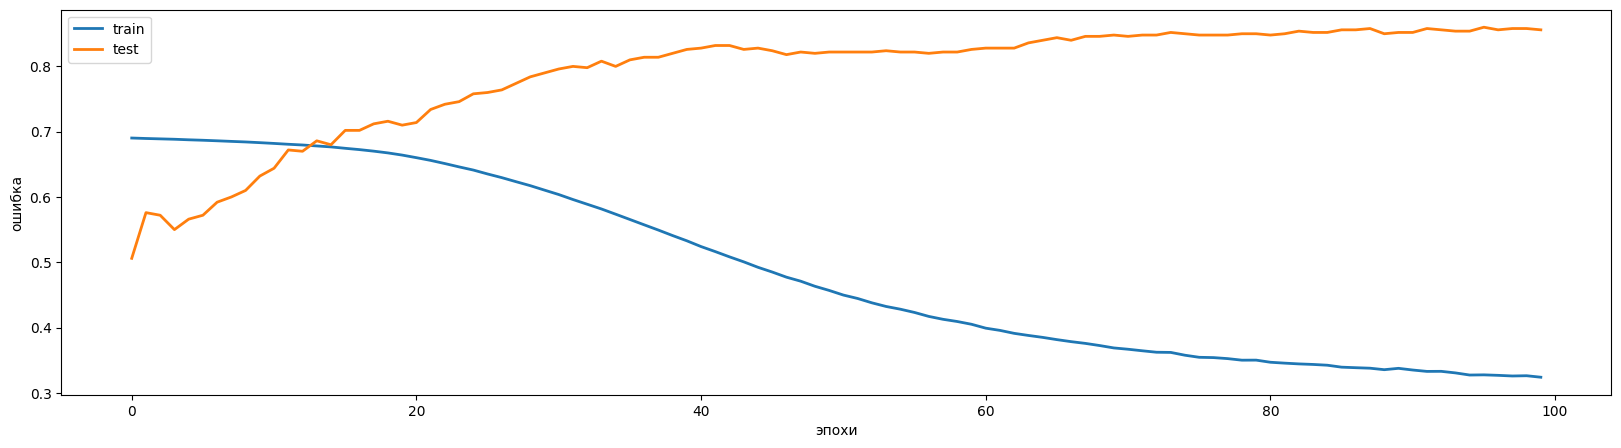

In [120]:
plt.figure(figsize=(20, 5))
plt.plot(train_losses, lw=2, label='train')
plt.plot(test_losses, lw=2, label='test')
plt.xlabel('эпохи')
plt.ylabel('ошибка')
plt.legend()

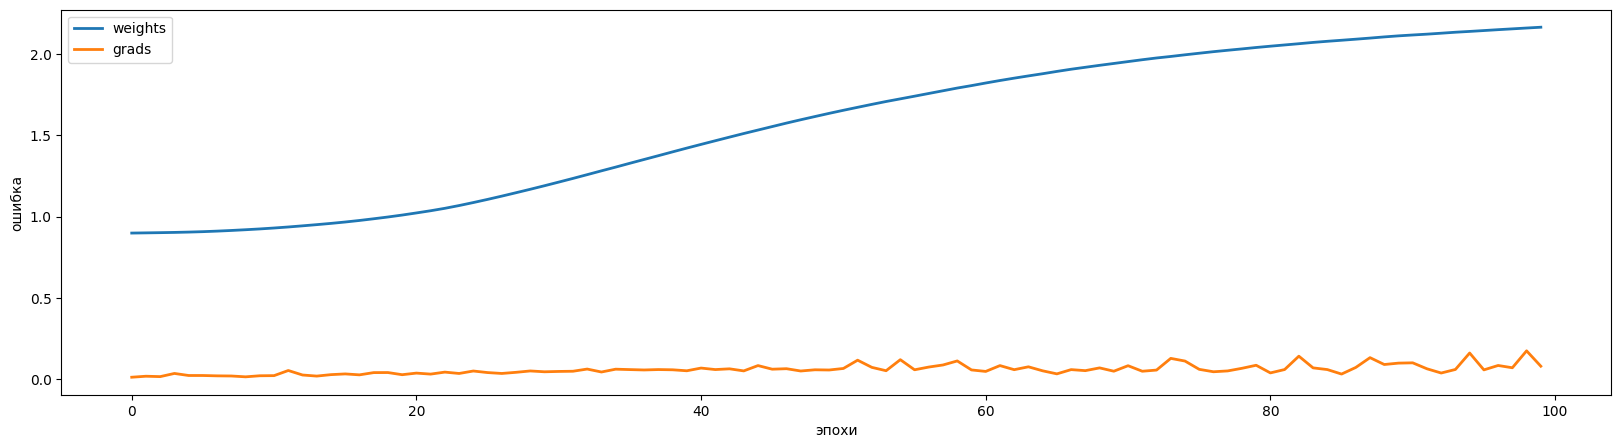

In [121]:
plt.figure(figsize=(20, 5))
plt.plot(weights, lw=2, label='weights')
plt.plot(grads, lw=2, label='grads')
plt.xlabel('эпохи')
plt.ylabel('ошибка')
plt.legend()

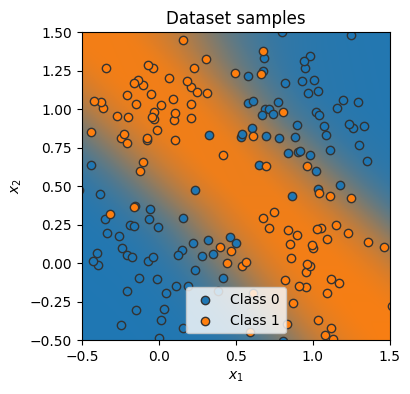

In [122]:
model.eval()
visualize_classification(model, dataset.data, dataset.label)
plt.show()